In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Set2")

df = pd.read_csv('Loan-Approval-Prediction.csv')

categorical = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 
               'Property_Area']

numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Split into training and test sets

Ideally, to avoid data leakage, no data from the test set should be used in preprocessing, so we'll split into training and test sets beforehand. Given that we have less than 1000 rows, we'll have a relatively small test set and make an 80:20 split. We can also drop the loan ID since this won't be used in modelling. 

In [43]:
#Separate target out and remove loan ID column
X = df.iloc[:, 1:].copy()
y = X.pop('Loan_Status')

We encode the target as a binary, applying the convention that the minority class is labelled as positive.

In [44]:
y = y.apply(lambda x: 1 if x=='N' else 0)

In [45]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21, stratify=y)

In [46]:
#Check shapes of splits
[split.shape for split in [X_train, X_test, y_train, y_test]]

[(491, 11), (123, 11), (491,), (123,)]

In [47]:
#Check class distribution in target splits
print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), sep='\n\n')

0    0.686354
1    0.313646
Name: Loan_Status, dtype: float64

0    0.691057
1    0.308943
Name: Loan_Status, dtype: float64


### Impute missing values

- For the categorical columns (including the loan term), we'll replace all nulls with the most frequent value. Given that 8% of the credit history values are null, this isn't ideal, but they mostly (~84%) take the value 1, so this seems reasonable in this case.
- Since the other numerical columns are right-skewed, we'll replace the nulls with the median rather than the mean.  

In [48]:
#Check nulls
X.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [50]:
#Impute missing values with median
value = {'LoanAmount': X_train.loc[:, ('LoanAmount')].median()}
X_train = X_train.fillna(value=value)
X_test = X_test.fillna(value=value)  

In [51]:
#Impute missing values with most frequent value
for col in categorical + ['Loan_Amount_Term']:
    value = {col: X_train.loc[:, (col)].value_counts().index[0]}
    X_train = X_train.fillna(value=value)
    X_test = X_test.fillna(value=value)

In [52]:
#Check for nulls in data
print(X_train.isna().sum().sum(), X_test.isna().sum().sum())

0 0


### Preprocessing

First we'll recast our datatypes where appropriate.

In [29]:
for data in X_train, X_test:
    data = data.astype({'CoapplicantIncome': 'int64', 
                        'LoanAmount': 'int64', 
                        'Loan_Amount_Term': 'int64', 
                        'Credit_History': 'int64'})
    print(data.dtypes, '\n')

Gender               object
Married              object
Dependents           object
Education            object
Self_Employed        object
ApplicantIncome       int64
CoapplicantIncome     int64
LoanAmount            int64
Loan_Amount_Term      int64
Credit_History        int64
Property_Area        object
dtype: object 

Gender               object
Married              object
Dependents           object
Education            object
Self_Employed        object
ApplicantIncome       int64
CoapplicantIncome     int64
LoanAmount            int64
Loan_Amount_Term      int64
Credit_History        int64
Property_Area        object
dtype: object 



We note the following with regard to encoding each feature. 
- Gender, Married, Education, Self_Employed and Credit_History are binary, so we'll one-hot encode these. Property_Area takes three values but there doesn't appear to be any inherent ordering so we'll also one-hot encode this and drop a redundant column.
- Dependents takes string values 0, 1, 2 and 3+. There is an ordering here so we could cast these as integers 0, 1, 2, 3, respectively, but note that this doesn't take into account the fact that a label 3 could then indicate any number of dependents from 3 upwards, while the other labels exactly match the data. Given this, we'll simply one-hot encode these as well, dropping a redundant column, as is standard.
- ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term are all numeric and take only positive values, so we'll scale these using a MinMaxScaler().

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [56]:
transformers = [('categorical', OneHotEncoder(sparse=True, handle_unknown='ignore'), categorical), 
                ('numerical', MinMaxScaler(feature_range=(0,1)), numerical)]

col_transform = ColumnTransformer(transformers=transformers, remainder='passthrough')

### Modelling

We now test a suite of classifiers with default parameters using repeated stratified cross-validation with three repeats and three folds. We monitor both accuracy and F1 score to ensure that we have a good balance between overall accuracy, recall and precision.

In [118]:
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer, f1_score, average_precision_score

#Define metrics
accs = make_scorer(accuracy_score)
f1 = make_scorer(fbeta_score, beta=1)
aps = make_scorer(average_precision_score)

In [60]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

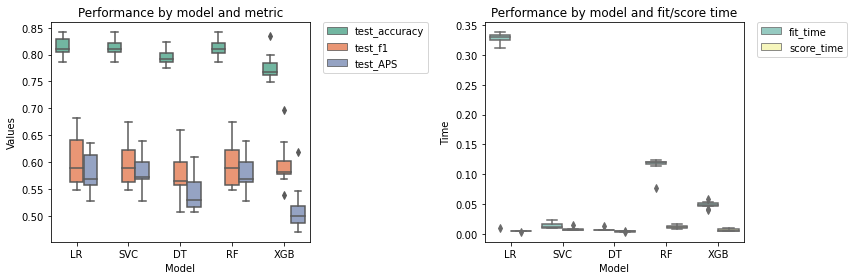

In [119]:
# Define classifiers
classifiers = [
    ('LR', LogisticRegression(solver='lbfgs', max_iter=1500)),
    ('SVC', SVC(gamma='scale', max_iter=1500)),
    ('DT', DecisionTreeClassifier(max_depth=4)),
    ('RF', RandomForestClassifier(max_depth=3)),
    ('XGB', XGBClassifier(max_depth=3))
]

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

results = []

for name, classifier in classifiers:
#     define data prep and pipeline
    pipeline = Pipeline(steps=[('preprocessing', col_transform), ('modelling', classifier)])

#     evaluate pipeline using cross validation 
    scores = cross_validate(pipeline, X_train, y_train, 
                            scoring={'accuracy': accs, 'f1': f1, 'APS': aps}, 
                            cv=cv, n_jobs=-1, error_score='raise')
    result = pd.DataFrame(scores)
    result['model'] = name
    results.append(result)
    
    #In case we need them later
#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_train)
#     yhat = pipeline.predict(X_test)

final = pd.concat(results, ignore_index=True)
time_metrics = [col for col in final.columns if 'time' in col]
test_metrics = [col for col in final.columns if 'test' in col]

#Plot results
final_test = pd.melt(final, id_vars=['model'], value_vars=test_metrics,
                     var_name='metric')
final_times = pd.melt(final, id_vars=['model'], value_vars=time_metrics,
                     var_name='metric')

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.boxplot(x='model', y='value', data=final_test, hue='metric', palette='Set2', ax=ax[0])
sns.boxplot(x='model', y='value', data=final_times, hue='metric', palette='Set3', ax=ax[1])

ax[0].set_ylabel('Values')
ax[0].set_xlabel('Model')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[0].set_title('Performance by model and metric')

ax[1].set_ylabel('Time')
ax[1].set_xlabel('Model')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[1].set_title('Performance by model and fit/score time')

plt.tight_layout();


The models appear to perform similarly in both accuracy and F1 score, and the overall accuracy is good at about 80–85% compared to a baseline of 69%. 

Let's rerun the experiments with class weights balanced to see if the class imbalance is having a negative effect. For the XGBoost classifier, a good starting value for scale_pos_weight is the ratio of negative to positive examples in the dataset, which in our case is given as follows.

In [73]:
y_train.value_counts()[0] / y_train.value_counts()[1]

2.188311688311688

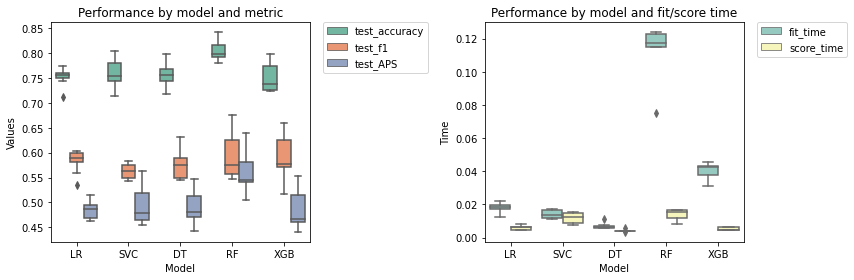

In [120]:
# Define balanced classifiers
classifiers = [
    ('LR', LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)),
    ('SVC', SVC(gamma='scale', class_weight='balanced', max_iter=1000)),
    ('DT', DecisionTreeClassifier(class_weight='balanced', max_depth=4)),
    ('RF', RandomForestClassifier(class_weight = 'balanced', max_depth=4)),
    ('XGB', XGBClassifier(scale_pos_weight=2.19, max_depth=3))
]


# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

results = []

for name, classifier in classifiers:
#     define data prep and pipeline
    pipeline = Pipeline(steps=[('preprocessing', col_transform), ('modelling', classifier)])

#     evaluate pipeline using cross validation 
    scores = cross_validate(pipeline, X_train, y_train, 
                            scoring={'accuracy': accs, 'f1': f1, 'APS': aps}, 
                            cv=cv, n_jobs=-1, error_score='raise')
    result = pd.DataFrame(scores)
    result['model'] = name
    results.append(result)
    
    #In case we need them later
#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_train)
#     yhat = pipeline.predict(X_test)

final = pd.concat(results, ignore_index=True)
time_metrics = [col for col in final.columns if 'time' in col]
test_metrics = [col for col in final.columns if 'test' in col]

#Plot results
final_test = pd.melt(final, id_vars=['model'], value_vars=test_metrics,
                     var_name='metric')
final_times = pd.melt(final, id_vars=['model'], value_vars=time_metrics,
                     var_name='metric')

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.boxplot(x='model', y='value', data=final_test, hue='metric', palette='Set2', ax=ax[0])
sns.boxplot(x='model', y='value', data=final_times, hue='metric', palette='Set3', ax=ax[1])

ax[0].set_ylabel('Values')
ax[0].set_xlabel('Model')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[0].set_title('Performance by model and metric')

ax[1].set_ylabel('Time')
ax[1].set_xlabel('Model')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[1].set_title('Performance by model and fit/score time')

plt.tight_layout();


If the class balance was causing any issues, we'd expect a noticable improvement in F1 score but in general the performance is similar (perhaps slightly worse) so we'll stick with using the unbalanced versions.

We'll now fit and assess the performance of the logistic regression and SVC models.

In [84]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay

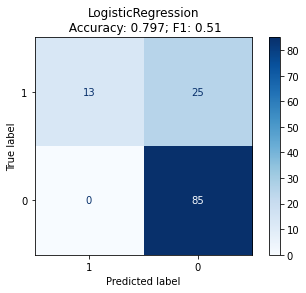

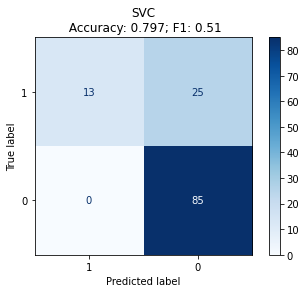

In [115]:
models = [('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=1500)), 
          ('SVC', SVC(gamma='scale', max_iter=1500))]

for title, model in models:
    pipe = Pipeline(steps=[('preprocessing', col_transform), (title.lower(), model)])
    pipe.fit(X_train, y_train)
    
    #Get predictions
    yhat = pipe.predict(X_test)
    
    acc = round(pipe.score(X_test, y_test), 3)
    fscore = round(f1_score(y_test, yhat), 3)
    
    #Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, yhat, labels=[1,0]), display_labels=[1,0])
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.title(f'{title}\n Accuracy: {acc}; F1: {fscore}');

Interestingly, logistic regression and SVC appear to perform exactly the same. In examining the boxplots, it seems that the median accuracy and F1 scores are very similar and there is definitely some variation between the CV scores, so this is perhaps a little surprising. We can check to see if the models made exactly the same classifications by comparing the two arrays of predictions. We also note at this stage that recall is poor and precision is good (there are 25 false negatives and no false positives).

In [117]:
lr = Pipeline(steps=[('preprocessing', col_transform), ('LR', models[0][1])])
svc = Pipeline(steps=[('preprocessing', col_transform), ('SVC', models[1][1])])

yhat_lr = lr.predict(X_test)
yhat_svc = svc.predict(X_test)

sum(yhat_lr == yhat_svc) == len(X_test)

True

So it seems that in fact the two models made exactly the same predictions.

Given that they perform the same and the dataset is small enough that computation time isn't an issue, we'll gridsearch both to obtain the optimum hyperparameters.